# Ensemble Model

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Flatten,  GRU
from tensorflow.keras import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import GlorotNormal, HeNormal, Orthogonal, VarianceScaling
import matplotlib.pyplot as plt
import seaborn as sns

### Load data

In [2]:
print('Reading data')
trn = pd.read_hdf('train.h5')
val = pd.read_hdf('validation.h5')
tst = pd.read_hdf('test.h5')

val = val.sample(frac=1).reset_index(drop=True)
tst = tst.sample(frac=1).reset_index(drop=True)

max_sequence_length = 8000

# sequences to list of integers
print('Splitting events')
trn['Events_removed'] = trn['Events_removed'].apply(lambda x: [int(e) for e in x.split(',')[:max_sequence_length]])
val['Events_removed'] = val['Events_removed'].apply(lambda x: [int(e) for e in x.split(',')[:max_sequence_length]])
tst['Events_removed'] = tst['Events_removed'].apply(lambda x: [int(e) for e in x.split(',')[:max_sequence_length]])

# Padding sequences to ensure uniform length
X = pad_sequences(trn['Events_removed'], maxlen=max_sequence_length)
V = pad_sequences(val['Events_removed'], maxlen=max_sequence_length)
T = pad_sequences(tst['Events_removed'], maxlen=max_sequence_length)


Reading data
Splitting events


In [3]:
X_train, y_train= X, trn['Onsite']
X_val, y_val= V, val['Onsite']
X_test, y_test = T, tst['Onsite']

### Define model architecture, train and test functions

In [4]:
def get_model(initializer):
    """
    Create a Sequential Dense model with specified initializer.

    This function creates a Sequential Dense model with the specified initializer for the kernel weights
    of each Dense layer. The model architecture consists of several Dense layers with ReLU activation,
    followed by a final Dense layer with sigmoid activation for binary classification.

    Parameters:
        initializer (str or initializer object): The initializer to use for the kernel weights
            of the Dense layers.

    Returns:
        tf.keras.Model: The compiled Sequential Dense model.

    Example:
        model = get_model('glorot_uniform')
    """
    
    model = Sequential([
            Flatten(input_shape=(8000,1)),
            Dense(8192, activation='relu', kernel_initializer=initializer),
            Dense(4096, activation='relu', kernel_initializer=initializer),
            Dense(2048, activation='relu', kernel_initializer=initializer),
            Dense(1024, activation='relu', kernel_initializer=initializer),
            Dense(512, activation='relu', kernel_initializer=initializer),
            Dense(256, activation='relu', kernel_initializer=initializer),
            Dense(126, activation='relu', kernel_initializer=initializer),
            Dense(64, activation='relu', kernel_initializer=initializer),
            Dense(32, activation='relu', kernel_initializer=initializer),
            Dropout(.2),
            Dense(1, activation='sigmoid')
        ])
    optim = tf.keras.optimizers.Adam(1e-3)
    model.compile(optimizer=optim, metrics=['accuracy'], loss=BinaryCrossentropy())
    return model

In [5]:
def get_gru_model():
    """
    Define and compile the GRU model.
    
    The model architecture consists of 2 GRU layers with ReLU activation,
    followed by a final Dense layer with sigmoid activation for binary classification.
    
    Returns:
        tf.keras.Sequential: Compiled GRU model.
    """
    model = Sequential([
        GRU(128, activation='relu', input_shape=(8000,1), return_sequences=True),
        Dropout(.1),
        GRU(64, activation='relu'),
        Dropout(.1),
        Dense(1, activation='sigmoid')
    ])
    optim = tf.keras.optimizers.Adam(1e-3)
    model.compile(optimizer=optim, metrics=['accuracy'], loss=BinaryCrossentropy())
    return model

In [6]:
def train(x, y, model, x_val, y_val, epochs=1000):
    """
    Train the neural network model with early stopping.
    
    Parameters:
        x (numpy.ndarray): Input features for training.
        y (numpy.ndarray): Target labels for training.
        model (tf.keras.Sequential): Compiled neural network model.
        x_val (numpy.ndarray): Input features for validation.
        y_val (numpy.ndarray): Target labels for validation.
        epochs (int): Number of epochs for training.
        
    Returns:
        tf.keras.Sequential: Trained neural network model.
    """
    
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, mode='min', patience=5, verbose=1, restore_best_weights=True)
    model.fit(x, y, epochs=epochs, validation_data=(x_val, y_val), callbacks=[es])
    return model

In [7]:
def test(x_test, y_test, models):
    """
    Test the ensemble of neural network models and calculate accuracy and uncertainty.
    
    Parameters:
        x_test (numpy.ndarray): Input features for testing.
        y_test (numpy.ndarray): Target labels for testing.
        models (list): List of trained neural network models.
        
    Returns:
        numpy.ndarray: Array of average predicted probabilities.
        numpy.ndarray: Array of standard deviations.
    """
    
    l = []
    correct_predictions = 0
    uncertain_predictions = 0
    total_probs = np.zeros(len(x_test))
    
    for model in models:
        probabilities = model.predict(x_test)
        temp = [prob[0] for prob in probabilities]
        l.append(temp)
        total_probs = total_probs + np.asarray(temp)
        
    sd = np.std(np.array(l),axis = 0) 
    total_probs = total_probs/len(models)
    for i in range(len(total_probs)):
        probs = total_probs[i]
        y_true = y_test.iloc[i] 

        # Classify predictions
        predicted_class = 1 if probs > 0.56 else 0 if probs < 0.54 else 0.5
        
        # Count uncertain predictions
        if predicted_class == 0.5:
            uncertain_predictions += 1
            continue

        # Count correct predictions
        if predicted_class == y_true:
            correct_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / (len(x_test) - uncertain_predictions)
    print('Ensemble Accuracy:', accuracy)
    
    # Calculate uncertainty
    uncertainity = uncertain_predictions / len(x_test)
    print('Ensemble Uncertainty: ', uncertainity)
    
    return total_probs, sd

### Train the model

In [8]:
models = []

print("GlorotNormal")
golort = get_model(GlorotNormal())
golort = train(x=X_train, y=y_train, model=golort, x_val=X_val, y_val=y_val)
models.append(golort)

GlorotNormal
Epoch 1/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.4776 - loss: 819.9654 - val_accuracy: 0.5707 - val_loss: 0.6841
Epoch 2/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5192 - loss: 0.8021 - val_accuracy: 0.5707 - val_loss: 0.6839
Epoch 3/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5200 - loss: 0.6963 - val_accuracy: 0.5707 - val_loss: 0.6840
Epoch 4/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5498 - loss: 0.6886 - val_accuracy: 0.5707 - val_loss: 0.6838
Epoch 5/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5568 - loss: 0.6843 - val_accuracy: 0.5707 - val_loss: 0.6838
Epoch 6/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5590 - loss: 0.6859 - val_accuracy: 0.5707 - val_loss: 0.6856
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.


In [9]:
trn = trn.sample(frac=1).reset_index(drop=True)
X = pad_sequences(trn['Events_removed'], maxlen=max_sequence_length)
X_train, y_train= X, trn['Onsite']

print("HeNormal")
henorm = get_model(HeNormal())
henorm = train(x=X_train, y=y_train, model=henorm, x_val=X_val, y_val=y_val)
models.append(henorm)

HeNormal
Epoch 1/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.4981 - loss: 3312.8965 - val_accuracy: 0.5707 - val_loss: 1.7986
Epoch 2/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.4606 - loss: 0.9487 - val_accuracy: 0.5707 - val_loss: 0.6930
Epoch 3/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5459 - loss: 0.6929 - val_accuracy: 0.5707 - val_loss: 0.6918
Epoch 4/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5636 - loss: 0.6916 - val_accuracy: 0.5707 - val_loss: 0.6906
Epoch 5/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5494 - loss: 0.6912 - val_accuracy: 0.5707 - val_loss: 0.6896
Epoch 6/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5519 - loss: 0.6904 - val_accuracy: 0.5707 - val_loss: 0.6886
Epoch 7/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5612 - loss: 0.6891 - val_accuracy: 0.5707 - val_loss: 0.6878
Epoch 8/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5653 - loss: 0.687

In [10]:
trn = trn.sample(frac=1).reset_index(drop=True)
X = pad_sequences(trn['Events_removed'], maxlen=max_sequence_length)
X_train, y_train= X, trn['Onsite']

print("Orthogonal")
ortho = get_model(Orthogonal())
ortho = train(x=X_train, y=y_train, model=ortho, x_val=X_val, y_val=y_val)
models.append(ortho)

Orthogonal
Epoch 1/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.4918 - loss: 248.0648 - val_accuracy: 0.5621 - val_loss: 0.6931
Epoch 2/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.5127 - loss: 0.7195 - val_accuracy: 0.5707 - val_loss: 0.6865
Epoch 3/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.5229 - loss: 0.6906 - val_accuracy: 0.5707 - val_loss: 0.6850
Epoch 4/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.5554 - loss: 0.6898 - val_accuracy: 0.5707 - val_loss: 0.6836
Epoch 5/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5555 - loss: 0.6890 - val_accuracy: 0.5707 - val_loss: 0.6840
Epoch 6/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.5436 - loss: 0.6895 - val_accuracy: 0.5707 - val_loss: 0.6857
Epoch 7/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.5506 - loss: 0.6887 - val_accuracy: 0.5707 - val_loss: 0.6835
Epoch 8/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.5491 - loss: 0.68

In [11]:
trn = trn.sample(frac=1).reset_index(drop=True)
X = pad_sequences(trn['Events_removed'], maxlen=max_sequence_length)
X_train, y_train= X, trn['Onsite']

print("VarianceScaling")
variance = get_model(VarianceScaling(scale=0.1, mode='fan_in', distribution='uniform'))
variance = train(x=X_train, y=y_train, model=variance, x_val=X_val, y_val=y_val)
models.append(variance)

VarianceScaling
Epoch 1/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.5308 - loss: 0.7142 - val_accuracy: 0.5707 - val_loss: 0.6889
Epoch 2/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5504 - loss: 0.6895 - val_accuracy: 0.5707 - val_loss: 0.6854
Epoch 3/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5586 - loss: 0.6866 - val_accuracy: 0.5707 - val_loss: 0.6846
Epoch 4/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5485 - loss: 0.6890 - val_accuracy: 0.5707 - val_loss: 0.6845
Epoch 5/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5430 - loss: 0.6899 - val_accuracy: 0.5707 - val_loss: 0.6843
Epoch 6/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.5535 - loss: 0.6881 - val_accuracy: 0.5707 - val_loss: 0.6845
Epoch 7/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5565 - loss: 0.6870 - val_accuracy: 0.5707 - val_loss: 0.6843
Epoch 8/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.5481 - loss: 0

In [12]:
trn = trn.sample(frac=1).reset_index(drop=True)
X = pad_sequences(trn['Events_removed'], maxlen=max_sequence_length)
X_train, y_train= X, trn['Onsite']

print("GRU")
gru = get_gru_model()
gru = train(x=X_train, y=y_train, model=gru, x_val=X_val, y_val=y_val)
models.append(gru)

GRU
Epoch 1/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 1183s 13s/step - accuracy: 0.5324 - loss: 1.7057 - val_accuracy: 0.5000 - val_loss: 0.7466
Epoch 2/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 1217s 14s/step - accuracy: 0.5125 - loss: 0.8377 - val_accuracy: 0.5278 - val_loss: 0.6929
Epoch 3/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 1203s 14s/step - accuracy: 0.5487 - loss: 0.7262 - val_accuracy: 0.5707 - val_loss: 0.6832
Epoch 4/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 1200s 13s/step - accuracy: 0.5166 - loss: 0.7103 - val_accuracy: 0.5749 - val_loss: 0.6813
Epoch 5/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 1211s 14s/step - accuracy: 0.5543 - loss: 0.6895 - val_accuracy: 0.5717 - val_loss: 0.6843
Epoch 6/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 1209s 14s/step - accuracy: 0.5578 - loss: 0.6883 - val_accuracy: 0.5278 - val_loss: 0.6912
Epoch 7/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 1201s 14s/step - accuracy: 0.5400 - loss: 0.6919 - val_accuracy: 0.5696 - val_loss: 0.6848
Epoch 8/1000
89/89 ━━━━━━━━━━━━━━━━━━━━ 1213s 14s/step - accuracy: 0.5340 - los

In [13]:
golort.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 8000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8192)                │      65,544,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      33,558,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2048)                │       8,390,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 126)                 │          32,382 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 330,870,911 (1.23 GB)

 Trainable params: 110,290,303 (420.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 220,580,608 (841.45 MB)

In [14]:
gru.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 8000, 128)           │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8000, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 262,853 (1.00 MB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 175,236 (684.52 KB)

### Model Validation

In [15]:
print('Validation')
probabilities, sd_list = test(X_val,y_val,models)
print("Standard Deviation: ", np.mean(sd_list))
print("Probability: ", np.mean(probabilities))

Validation
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step
Ensemble Accuracy: 0.5913978494623656
Ensemble Uncertainty:  0.9004282655246253
Standard Deviation:  0.010415124
Probability:  0.548975566023167


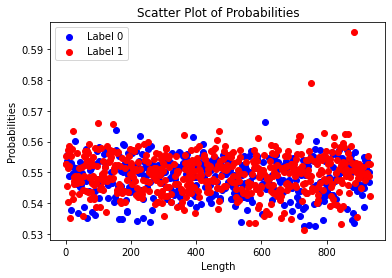

In [21]:
# Separate data points based on their true labels
points_label_0 = [(length, prob) for length, prob, label in zip(range(len(probabilities)), probabilities, y_val) if label == 0]
points_label_1 = [(length, prob) for length, prob, label in zip(range(len(probabilities)), probabilities, y_val) if label == 1]

# Extract x and y values for the scatter plot
x_label_0, y_label_0 = zip(*points_label_0)
x_label_1, y_label_1 = zip(*points_label_1)

plt.title('Scatter Plot of Probabilities')
plt.scatter(x_label_0, y_label_0, c='blue', label='Label 0')
plt.scatter(x_label_1, y_label_1, c='red', label='Label 1')
plt.xlabel('Length')
plt.ylabel('Probabilities')
plt.legend()
plt.show()

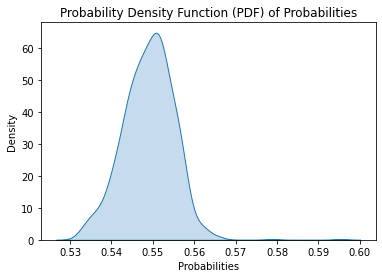

In [22]:
sns.kdeplot(probabilities, fill=True)
plt.title('Probability Density Function (PDF) of Probabilities')
plt.xlabel('Probabilities')
plt.ylabel('Density')
plt.show()

In [23]:
correct_prediction = 0 
uncertain_prediction = 0
standard_deviation =  np.mean(sd_list) / 2
total_data_points = len(y_val)

for i in range(total_data_points):
    prob = probabilities[i]
    
    # Define lower and upper bounds based on standard deviation
    lb = prob - standard_deviation
    ub = prob + standard_deviation
    
    # Classify predictions
    c = 1 if lb > .55 else 0 if ub < .55 else 0.5
    
    # Count uncertain predictions
    if c == 0.5:
        uncertain_prediction += 1
        continue
    
    # Count correct predictions
    if c == y_test.iloc[i]:
        correct_prediction += 1

In [27]:
print("Validation SD Accuracy: ", correct_prediction/(total_data_points - uncertain_prediction))
print("Validation SD Uncertainity", uncertain_prediction/total_data_points)

Validation SD Accuracy:  0.5
Validation SD Uncertainity 0.5767195767195767


### Model Testing

In [28]:
print('Testing')
probabilities, sd_list = test(X_test,y_test,models)
print("Standard Deviation: ", np.mean(sd_list))
print("Probability: ", np.mean(probabilities))

Testing
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step
30/30 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step
Ensemble Accuracy: 0.5643564356435643
Ensemble Uncertainty:  0.8931216931216931
Standard Deviation:  0.01046575
Probability:  0.5484600804659424


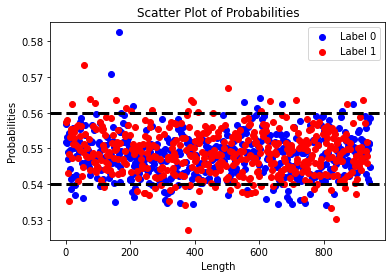

In [29]:
# Separate data points based on their true labels
points_label_0 = [(length, prob) for length, prob, label in zip(range(len(probabilities)), probabilities, y_test) if label == 0]
points_label_1 = [(length, prob) for length, prob, label in zip(range(len(probabilities)), probabilities, y_test) if label == 1]

# Extract x and y values for the scatter plot
x_label_0, y_label_0 = zip(*points_label_0)
x_label_1, y_label_1 = zip(*points_label_1)

plt.axhline(y=0.54, color='black', linestyle='--', linewidth=3)
plt.axhline(y=0.56, color='black', linestyle='--', linewidth=3)
plt.scatter(x_label_0, y_label_0, c='blue', label='Label 0')
plt.scatter(x_label_1, y_label_1, c='red', label='Label 1')
plt.title('Scatter Plot of Probabilities')
plt.xlabel('Length')
plt.ylabel('Probabilities')
plt.legend()
plt.show()

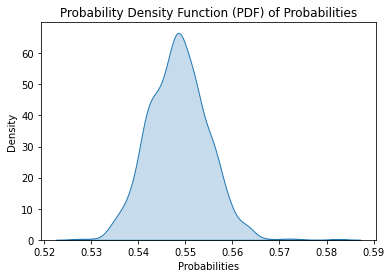

In [30]:
sns.kdeplot(probabilities, fill=True)
plt.title('Probability Density Function (PDF) of Probabilities')
plt.xlabel('Probabilities')
plt.ylabel('Density')
plt.show()

In [32]:
correct_prediction = 0 
uncertain_prediction = 0
standard_deviation = 0.0104/ 2
total_data_points = len(y_test)

for i in range(total_data_points):
    prob = probabilities[i]
    
    # Define lower and upper bounds based on standard deviation
    lb = prob - standard_deviation
    ub = prob + standard_deviation
    
    # Classify predictions
    c = 1 if lb > 0.55 else 0 if ub < 0.55 else 0.5
    
    # Count uncertain predictions
    if c == 0.5:
        uncertain_prediction += 1
        continue
    
    # Count correct predictions
    if c == y_test.iloc[i]:
        correct_prediction += 1

In [33]:
print("Validation SD Accuracy: ", correct_prediction/(total_data_points - uncertain_prediction))
print("Validation SD Uncertainity", uncertain_prediction/total_data_points)

Validation SD Accuracy:  0.525
Validation SD Uncertainity 0.5767195767195767
